In [141]:
import sys
print(sys.version)
import json
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt


3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [142]:
# TODO: Choose color palette https://seaborn.pydata.org/tutorial/color_palettes.html
MAIN_COLOR_1 = "#4664AA"
MAIN_COLOR_2 = "#7D92C3"
# TODO: Figure aesthetics https://seaborn.pydata.org/tutorial/aesthetics.html

sns.set(color_codes=True)

run = "writtenwork_depth"
res = pd.read_csv(f"out/_results_{run}.csv", index_col=0)
classes = list(res.index.values)

res

,n_t,n_b,m_g,dens_g,k_t,k_b,n_t_om,m_t,dens_t,k_t_om,n_b_om,m_b,dens_b,k_b_om,rc_t_dens,rc_t_ncomp,rc_t_slcc,rc_b_dens,rc_b_ncomp,rc_b_slcc
WrittenWork,90862.0,6235.0,1430486.0,0.002525,15.743501,229.428388,90862.0,2.887892e+09,0.699602,63569.341786,6235.0,289775.0,0.014910,92.951083,0.000549,NaN,NaN,0.000008,0.002261,0.002239
Comic,6688.0,996.0,123468.0,0.018535,18.461124,123.963855,6688.0,2.005113e+07,0.896688,5996.151017,996.0,30932.0,0.062425,62.112450,0.006494,0.017903,0.017125,0.000417,0.017248,0.017192
Manga,3783.0,459.0,81038.0,0.046670,21.421623,176.553377,3783.0,7.022957e+06,0.981730,3712.903516,459.0,11965.0,0.113832,52.135076,0.026932,0.045602,0.045571,0.002567,0.044223,0.044165
PeriodicalLiterature,22235.0,1743.0,368326.0,0.009504,16.565145,211.317269,22235.0,2.134585e+08,0.863552,19202.811443,1743.0,46922.0,0.030907,53.871412,0.002974,NaN,NaN,0.000112,0.009267,0.008647
AcademicJournal,7688.0,561.0,174820.0,0.040534,22.739334,311.622103,7688.0,2.839328e+07,0.960894,7387.351112,561.0,13269.0,0.084473,47.389286,0.026015,NaN,NaN,0.001846,0.040222,0.038316
Magazine,6728.0,1011.0,102287.0,0.015038,15.203181,101.174085,6728.0,1.885800e+07,0.833332,5605.827586,1011.0,24330.0,0.047654,48.130564,0.006348,0.014457,0.014312,0.000269,0.013745,0.013649
Newspaper,8060.0,958.0,97900.0,0.012679,12.146402,102.192067,8060.0,2.741099e+07,0.843992,6805.111221,958.0,19522.0,0.042587,40.798328,0.005747,0.012682,0.012142,0.000192,0.012435,0.011292


In [156]:
# FiveFour graph
# G = nx.Graph()
# G.add_edges_from([(1,6),(1,7),(1,8),(2,6),(2,7),(2,8),(3,6),(3,7),(3,8),(3,9),(4,8),(4,9),(5,9)])

# Configuration model https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.generators.configuration_model.html#networkx.algorithms.bipartite.generators.configuration_model
# Havel Hakimi graph https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.generators.havel_hakimi_graph.html#networkx.algorithms.bipartite.generators.havel_hakimi_graph
# gnmk random graph https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.bipartite.generators.gnmk_random_graph.html#networkx.algorithms.bipartite.generators.gnmk_random_graph

tseq = [3, 3, 4, 2, 1]
bseq = [4, 3, 3, 3]
G = nx.bipartite.configuration_model(tseq, bseq, create_using=nx.Graph()) # create_using=nx.Graph() # No parallel edges
print("n", G.number_of_nodes())
print("m", G.number_of_edges())
print(G.edges)
print(G.nodes)
print(G.nodes(data="bipartite"))

# The nodes are assigned the attribute ‘bipartite’ with the value 0 or 1 to indicate which bipartite set the node belongs to.
coloring = nx.greedy_color(G, strategy="largest_first")
nodecolors = []
for node in G.nodes():
    if coloring[node] == 0:
        nodecolors.append(MAIN_COLOR_1)
    else:
        nodecolors.append(MAIN_COLOR_2)

top = nx.bipartite.sets(G)[0]
bi_layout = nx.bipartite_layout(G, top, aspect_ratio=0.5, scale=0.2)
nx.draw_networkx(G, bi_layout, with_labels=True, font_size=6,node_color=nodecolors, edge_color="grey")


n 9
m 11
[(0, 5), (0, 7), (1, 8), (1, 6), (1, 5), (2, 5), (2, 6), (2, 8), (3, 7), (3, 5), (4, 8)]
[0, 1, 2, 3, 4, 5, 6, 7, 8]
[(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 1), (6, 1), (7, 1), (8, 1)]


In [157]:
class1 = classes[0]
with open(f"out/{class1}/{class1}.t.k.json", "r") as input_file:
    dist = json.load(input_file)

nnodes = 0
for key, value in dist.items():
    nnodes += value

n_t = res.loc[class1, "n_t"]
ndiscnodes = n_t - nnodes

x = []
y = []
for key, value in dist.items():
    x.append(int(key))
    y.append(float(value / nnodes))
    
print(f"{nnodes} nodes with degree >= 1 and {ndiscnodes} disconnected nodes")
x.append(0)
y.append(float(ndiscnodes / nnodes))

# plt.xscale("log")
plt.xlim(-200, 8000)
plt.yscale("log")
plt.ylim(0.00001, 0.8)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")

90858 nodes with degree >= 1 and 4.0 disconnected nodes


In [158]:
with open(f"out/{classes[0]}/{classes[0]}.b.k.json", "r") as input_file:
    dist = json.load(input_file)

nnodes = 0
for key, value in dist.items():
    nnodes += value

n_b = res.loc[classes[0], "n_b"]
ndiscnodes = n_b - nnodes

x = []
y = []
for key, value in dist.items():
    x.append(int(key))
    y.append(float(value / nnodes))
    
print(f"{nnodes} nodes with degree >= 1 and {ndiscnodes} disconnected nodes")
x.append(0)
y.append(float(ndiscnodes / nnodes))

# plt.xscale("log")
# plt.xlim(0.5, 50000)
plt.yscale("log")
plt.ylim(0.00005, 0.2)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

6235 nodes with degree >= 1 and 0.0 disconnected nodes


In [146]:
with open(f"out/{classes[0]}/{classes[0]}.t.w.json", "r") as input_file:
    dist = json.load(input_file)

nnodes = 0
for key, value in dist.items():
    if int(key) > 0:
        nnodes += value

x = []
y = []
for key, value in dist.items():
    if int(key) > 0:
        x.append(int(key))
        y.append(float(value / nnodes))

plt.xscale("log")
plt.xlim(0.5, 500)
plt.yscale("log")
plt.ylim(0.000000000001, 0.9)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

In [147]:
with open(f"out/{classes[0]}/{classes[0]}.b.w.json", "r") as input_file:
    dist = json.load(input_file)

sum = 0
for key, value in dist.items():
    if int(key) > 0:
        sum += value

x = []
y = []
for key, value in dist.items():
    if int(key) > 0:
        x.append(int(key))
        y.append(float(value / sum))

plt.xscale("log")
plt.xlim(0.5, 500000)
plt.yscale("log")
plt.ylim(0.000001, 0.8)
plt.scatter(x, y, color=MAIN_COLOR_2+"aa")
plt.show()

<IPython.core.display.Javascript object>


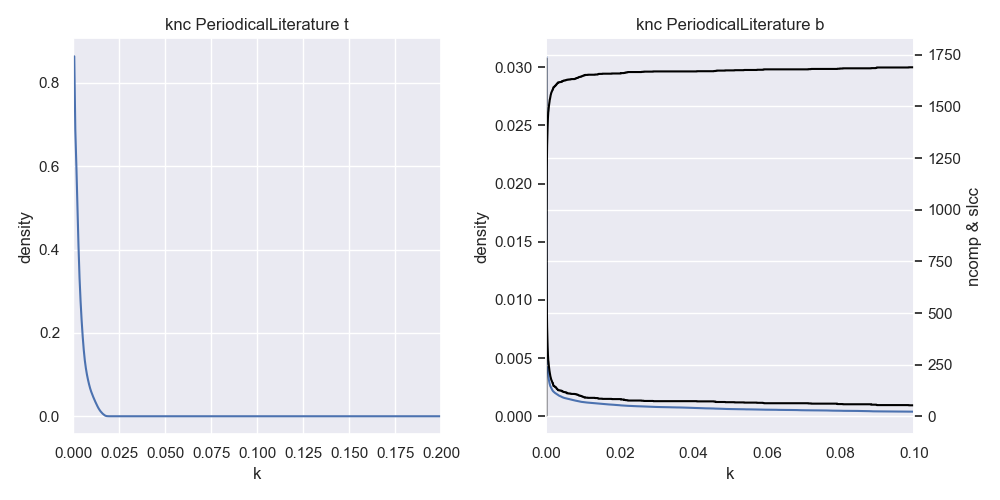

Newspaper 'ncomponents'


In [159]:
class1 = classes[3]

df_t = pd.read_csv(f"out/{class1}/{class1}.t.knc.csv", index_col=0)
df_b = pd.read_csv(f"out/{class1}/{class1}.b.knc.csv", index_col=0)

n_t = res.loc[class1, "n_t"]
n_b = res.loc[class1, "n_b"]
k_max_t = n_b
k_max_b = n_t
# w_max_t = 50


# knc_density = df["density"]
# knc_ncomponents = df["ncomponents"] # (n_t - df["ncomponents"]) / (n_t - 1)
# knc_slcc = df["slcc"] # (df["slcc"] - 1) / (n_t - 1)
# plt.xlim(0, w_max_t/k_max_t)
# plt.ylim(0, 1)
# plt.bar(df["k"]/k_max_t, knc_ncomponents, width=1/k_max_t, align="edge", color=MAIN_COLOR_1, edgecolor=MAIN_COLOR_2)

# plt.bar(df["k"]/k_max_t, knc_slcc, width=1/k_max_t, align="edge", color=MAIN_COLOR_1, edgecolor=MAIN_COLOR_2)
# ax = df["ncomponents"].plot()
# df["slcc"].plot(ax=ax)

df_t.index = df_t.index / k_max_t # Normalize k axis
df_b.index = df_b.index / k_max_b
# barwidth = 1 / k_max_t

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
try:
    df_t["density"].plot(ax=ax1, color="b", title=f"knc {class1} t") # .bar(width=barwidth, align="center") # kind="bar" # bar width not scaling with xlim
    df_t["ncomponents"].plot(ax=ax1, color="#000000", secondary_y=True)
    df_t["slcc"].plot(ax=ax1, color="#000000", secondary_y=True)
    ax1.right_ax.set_ylabel("ncomp & slcc")
except KeyError as e:
    print(classname, e)
ax1.set_xlim(0, 0.2)
ax1.set_ylabel("density")

try:
    df_b["density"].plot(ax=ax2, color="b", title=f"knc {class1} b") # .bar(width=barwidth, align="center") # kind="bar" # bar width not scaling with xlim
    df_b["ncomponents"].plot(ax=ax2, color="#000000", secondary_y=True)
    df_b["slcc"].plot(ax=ax2, color="#000000", secondary_y=True)
    ax2.right_ax.set_ylabel("ncomp & slcc")
except KeyError as e:
    print(classname, e)
ax2.set_xlim(0, 0.1)
ax2.set_ylabel("density")

fig.tight_layout() # plt.subplots_adjust(wspace=1)

<IPython.core.display.Javascript object>


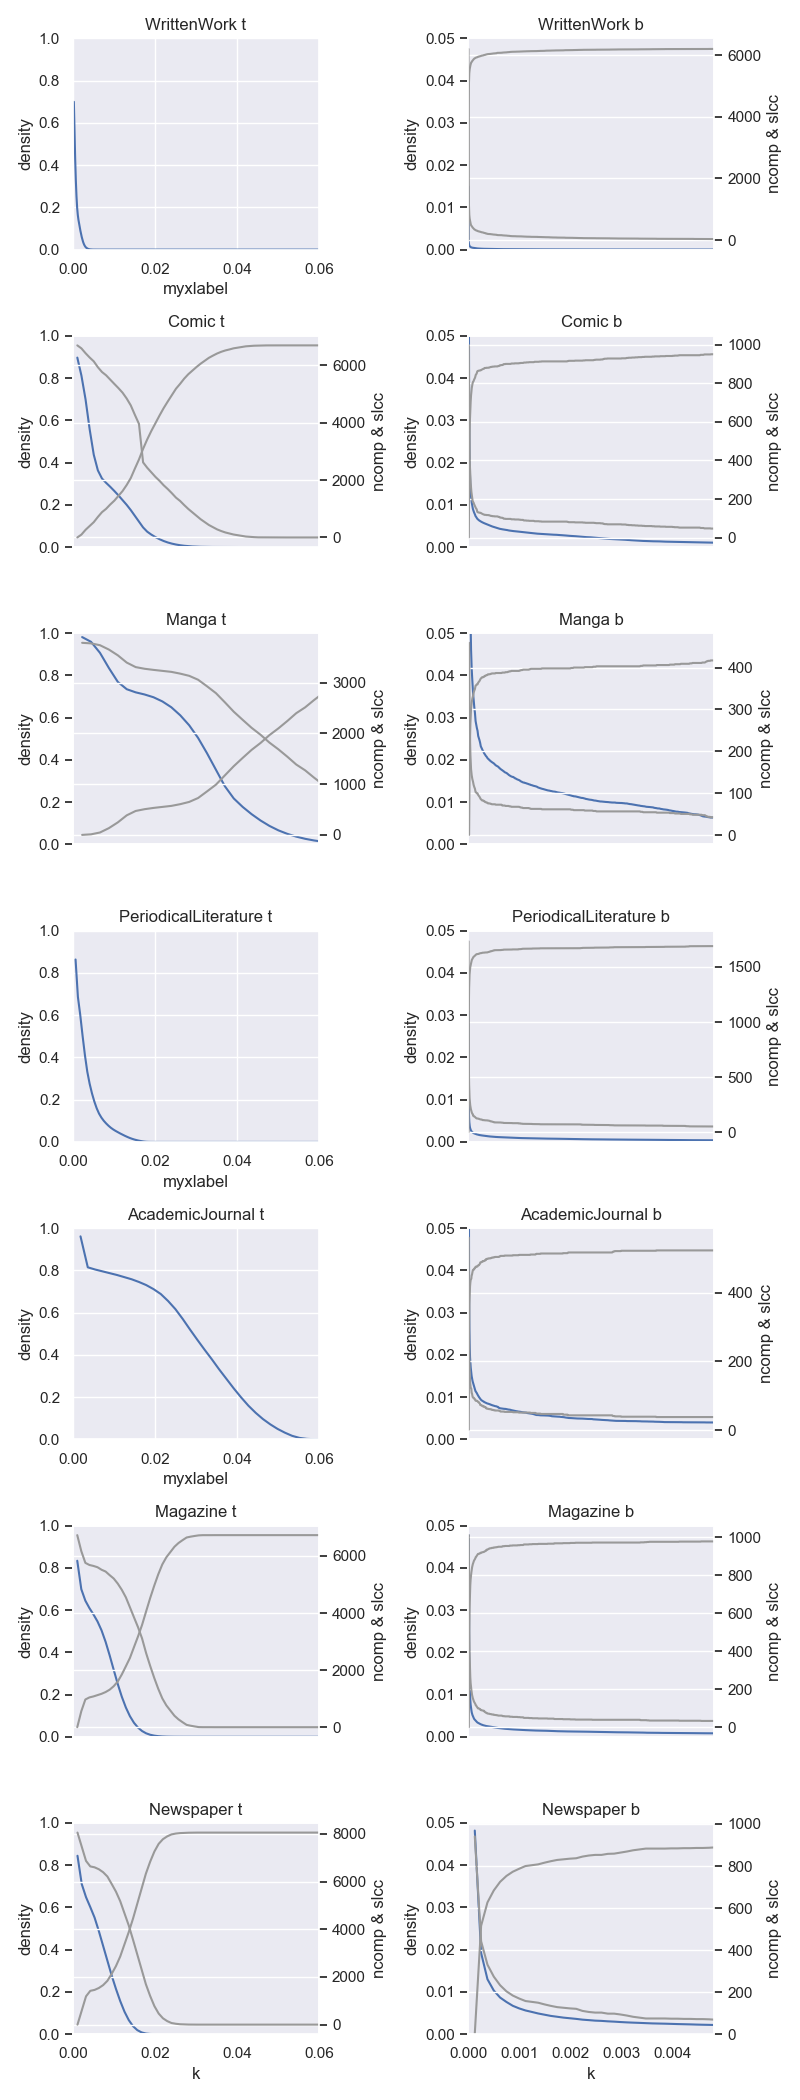

WrittenWork 'ncomponents'
PeriodicalLiterature 'ncomponents'
AcademicJournal 'ncomponents'


In [160]:
fig, axes = plt.subplots(len(classes), 2, figsize=(8, 3 * len(classes)))

for classname in classes:
    try:
        df_t = pd.read_csv(f"out/{classname}/{classname}.t.knc.csv", index_col=0)
        df_b = pd.read_csv(f"out/{classname}/{classname}.b.knc.csv", index_col=0)
    except FileNotFoundError as e:
        print(classname, e)

    n_t = res.loc[classname, "n_t"]
    n_b = res.loc[classname, "n_b"]

    df_t.index = df_t.index / n_b # Normalize k axis
    df_b.index = df_b.index / n_t

    axnr = classes.index(classname)
    df_t["density"].plot(x="k", ax=axes[axnr][0], color="b", title=f"{classname} t") # .bar(width=barwidth, align="center") # bar width not scaling with xlim
    axes[axnr][0].set_xlabel("myxlabel") # TODO: pandas issue, some xlables not showing
    try:
        df_t["ncomponents"].plot(ax=axes[axnr][0], color="#999999", secondary_y=True)
        df_t["slcc"].plot(ax=axes[axnr][0], color="#999999", secondary_y=True)
        axes[axnr][0].right_ax.set_ylabel("ncomp & slcc")
    except KeyError as e:
        print(classname, e)
    axes[axnr][0].set_xlim(0, 0.06)
    axes[axnr][0].set_ylim(0, 1)
    axes[axnr][0].set_ylabel("density")

    df_b["density"].plot(ax=axes[axnr][1], color="b", title=f"{classname} b") # .bar(width=barwidth, align="center") # bar width not scaling with xlim
    try:
        df_b["ncomponents"].plot(ax=axes[axnr][1], color="#999999", secondary_y=True)
        df_b["slcc"].plot(ax=axes[axnr][1], color="#999999", secondary_y=True)
        axes[axnr][1].right_ax.set_ylabel("ncomp & slcc")
    except KeyError as e:
        print(classname, e)
    axes[axnr][1].set_xlim(0, 0.1)
    axes[axnr][1].set_ylim(0, 0.05)
    axes[axnr][1].set_ylabel("density")

# plt.subplots_adjust(wspace=1, hspace=1)
# fig.tight_layout()
plt.tight_layout()
# plt.savefig("test.png",bbox_inches='tight')

In [161]:
class1 = classes[0]
df = pd.read_csv(f"out/{class1}/{class1}.t.knc.csv")

n_t = res.loc[class1, "n_t"]
n_b = res.loc[class1, "n_b"]
k_max_t = n_b
w_max_t = 30

knc_density = df["density"]
# knc_ncomponents = (n_b - df["ncomponents"]) / (n_b - 1)
# knc_slcc = (df["slcc"] - 1) / (n_b -1)

plt.xlim(0, w_max_t/k_max_t)
# plt.ylim(0, 1)
plt.bar(df["k"]/k_max_t, knc_density, width=1/k_max_t, align="edge", color=MAIN_COLOR_1, edgecolor=MAIN_COLOR_2)


<BarContainer object of 6235 artists>

<IPython.core.display.Javascript object>


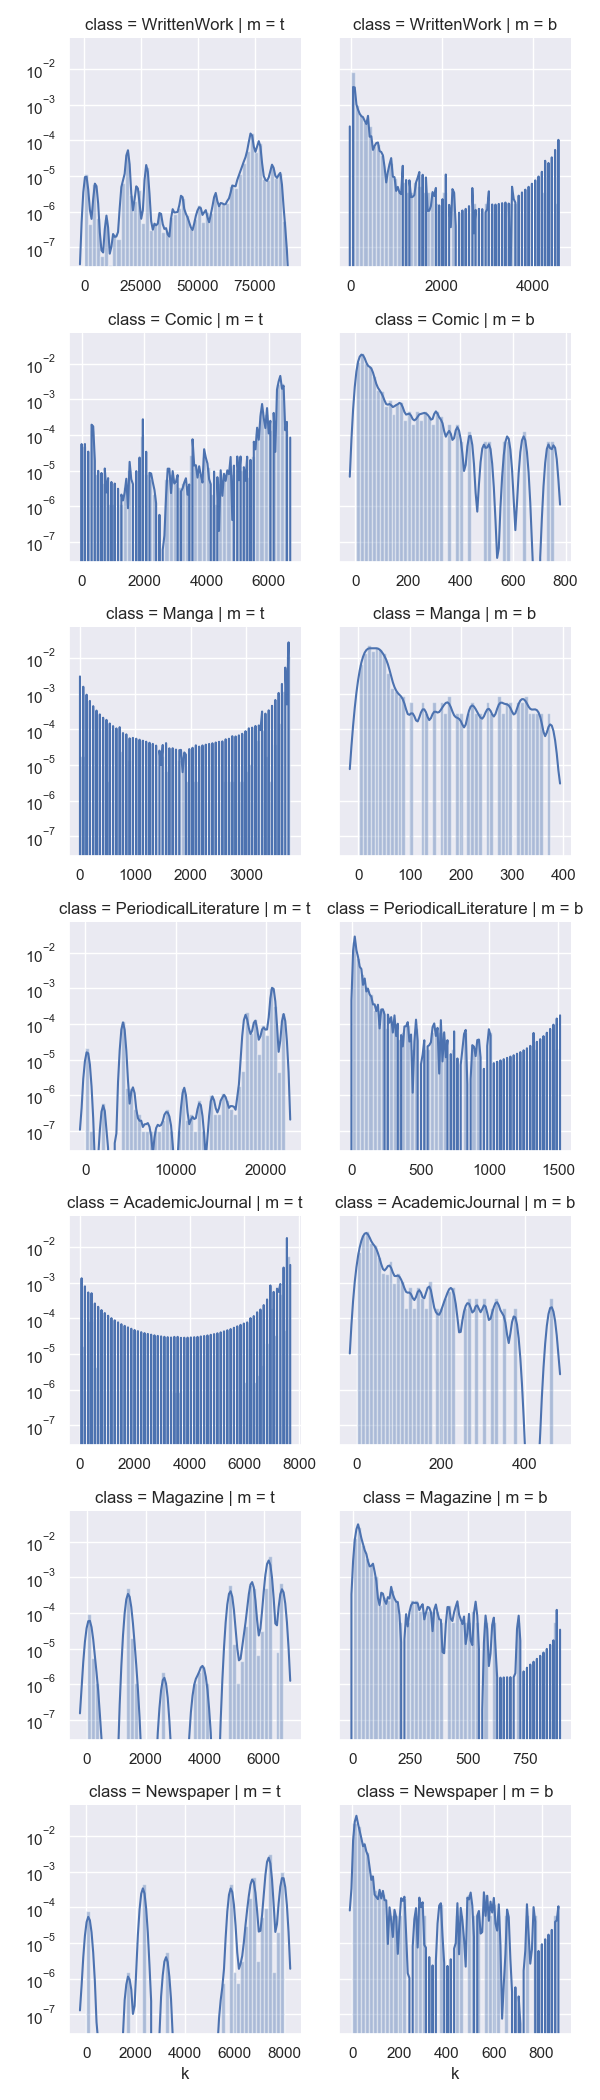

In [162]:
c = []
m = []
k = []
for classname in classes:
    with open(f"out/{classname}/{classname}.t.k.json", "r") as input_file:
        dist = json.load(input_file)
    for key, value in dist.items():
        for _ in range(0, value):
            c.append(classname)
            m.append("t")
#             k_max = res.
            k.append(int(key))
    with open(f"out/{classname}/{classname}.b.k.json", "r") as input_file:
        dist = json.load(input_file)
    for key, value in dist.items():
        for _ in range(0, value):
            c.append(classname)
            m.append("b")
            k.append(int(key))
#TODO: Normalize x axis
            
dct = {"class": c, "m": m, "k": k}
df = pd.DataFrame(dct)

fg = sns.FacetGrid(df, row="class", col="m", sharex=False)
fg.map(sns.distplot, "k")
fg.set(yscale="log")

<IPython.core.display.Javascript object>


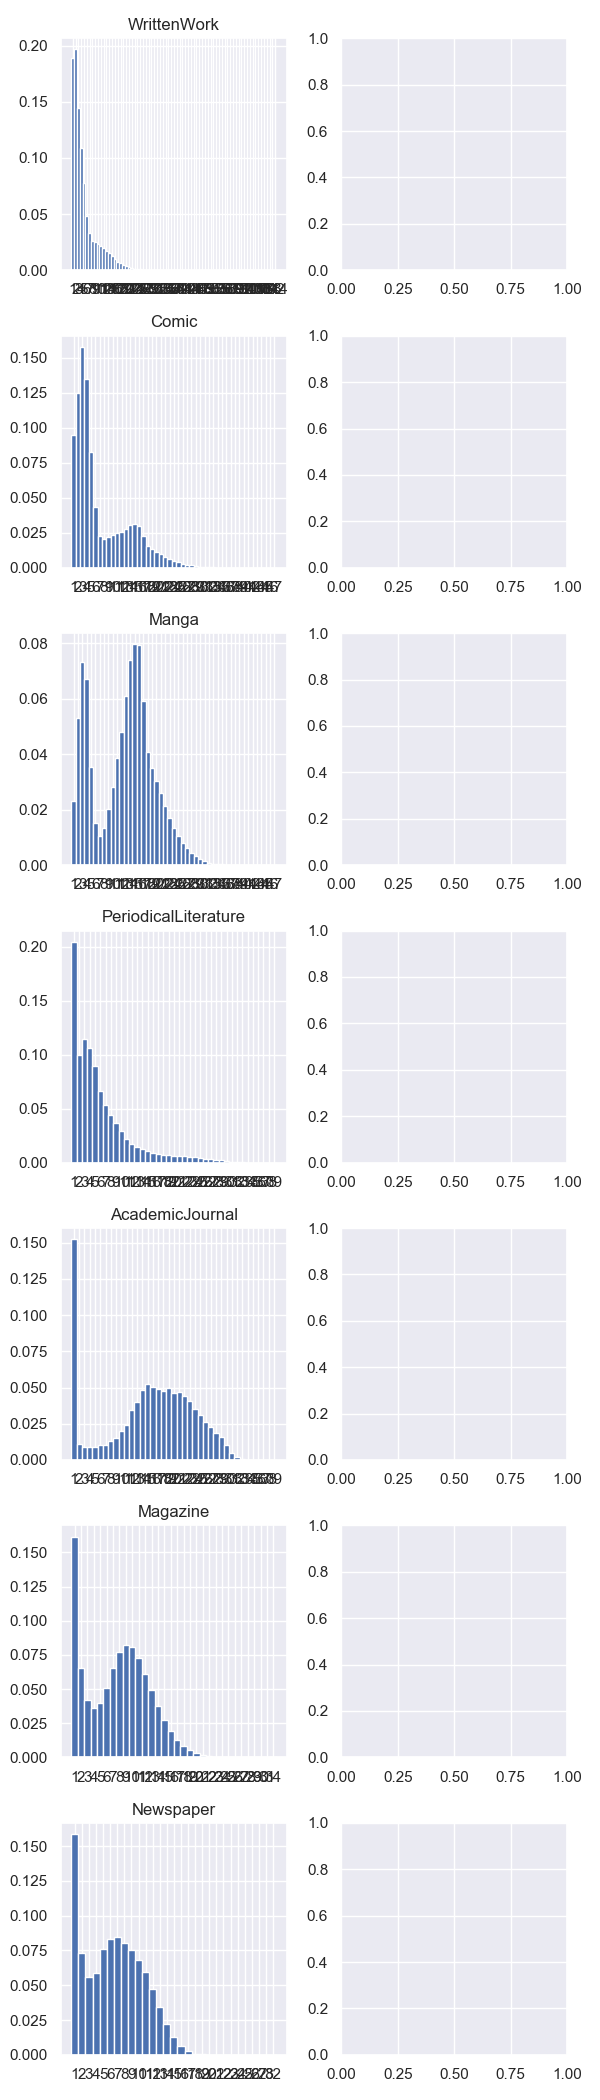

In [163]:
fig, axes = plt.subplots(len(classes), 2, figsize=(6, 3 * len(classes)))
for classname in classes:
    axnr = classes.index(classname)
    m_t = res.loc[classname, "m_t"]    
    w_max_t = res.loc[classname, "n_b"]
    w = []
    pw = []
    with open(f"out/{classname}/{classname}.t.w.json", "r") as input_file:
        dist = json.load(input_file)
    for key, value in dist.items():
        if int(key) > 0:
            w.append(key)
            pw.append(value / m_t)
    axes[axnr][0].bar(w, pw, width=1, align='center')
#     axes[axnr][0].set_xlim(1, w_max_t) #axis(xmin=1,xmax=w_max_t) # TODO: Set xlim
    axes[axnr][0].set_title(classname)

# plt.tick_params(axis='x', which='minor', labelsize=0.5)
plt.tight_layout()